In [2]:
import pandas as pd
from datetime import datetime
import csv
from matplotlib import pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import re
# from spellchecker import SpellChecker
import spacy
import seaborn as sns

In [3]:
pd.set_option("display.max_columns", None)
submission_df = pd.read_csv('submissions.csv')
submission_df.head()

,id,kind,category,created_utc,author,name,subreddit_id,subreddit_subscriber,subreddit,title,selftext,upvote_ratio,url,num_comments,ups,downs,total_awards_received,score,created,num_crossposts
0,slzdzs,t3,NaN,1.644162e+09,Independent_Bee_4468,t3_slzdzs,t5_2qs0k,51514,Home,What is this mud-like lump that recently appea...,NaN,0.50,https://www.reddit.com/gallery/slzdzs,28,0,0,0,0,1.644162e+09,0
1,qrti73,t3,NaN,1.636660e+09,TopSpite9394,t3_qrti73,t5_2qs0k,51514,Home,Any idea what this is? Sorry if this is a dumb...,NaN,0.60,https://www.reddit.com/gallery/qrti73,24,15,0,0,15,1.636660e+09,0
2,p1se4g,t3,NaN,1.628612e+09,villanegg,t3_p1se4g,t5_2qs0k,51514,Home,I just bought my first flat. First pic!,NaN,0.53,https://i.redd.it/ygtww9pv1kg71.jpg,6,1,0,0,1,1.628612e+09,0
3,oeiaps,t3,NaN,1.625525e+09,Cristheideaman,t3_oeiaps,t5_2qs0k,51514,Home,Exterior project my family completed follow on...,NaN,0.50,https://v.redd.it/sd1smhg84h971,0,0,0,0,0,1.625525e+09,0
4,nadi4r,t3,NaN,1.620784e+09,Nahughes121989,t3_nadi4r,t5_2qs0k,51514,Home,Loving my new living room setup. Just need a p...,NaN,0.59,https://i.redd.it/gt880tx8hly61.jpg,11,6,0,0,6,1.620784e+09,0


In [4]:
submission_df = submission_df.dropna(subset=['title'])
submission_df['selftext'].fillna(" ", inplace=True)
submission_df['transcript'] = submission_df['title'] + submission_df['selftext'] 
# group_submission = submission_df[['subreddit', 'transcript']].groupby('subreddit')
# submission_corpus = group_submission['transcript'].apply(lambda txt: " ".join(txt)).reset_index()
submission_df = submission_df.loc[:, ['subreddit', 'transcript']]
submission_df.head()

,subreddit,transcript
0,Home,What is this mud-like lump that recently appea...
1,Home,Any idea what this is? Sorry if this is a dumb...
2,Home,I just bought my first flat. First pic!
3,Home,Exterior project my family completed follow on...
4,Home,Loving my new living room setup. Just need a p...


In [5]:
comments_df = pd.read_csv('comments_.csv')
comments_df.head()

,author,body,created_utc,id,parent_id,subreddit,subreddit_id,score
0,LT-COL-Obvious,"Don’t shoot a BB gun at it, you’ll shoot your ...",1642012439,hsdpqpx,t3_s29o71,Home,t5_2qs0k,1
1,turkeyburpin,"1. Others are correct, check into your insulat...",1642011979,hsdohyq,t3_s29o71,Home,t5_2qs0k,1
2,c0ncept,These ripped an entire gutter off my old house...,1642011771,hsdnxhb,t3_s29o71,Home,t5_2qs0k,1
3,Jared944,Glue. Lots of glue. Glue it tight; glue it right.,1642011753,hsdnvrn,t3_s1uyss,Home,t5_2qs0k,1
4,PirateINDUSTRY,Nothing like doing sub-zero roofing work on yo...,1642010983,hsdlsv2,t1_hsdcpvs,Home,t5_2qs0k,1


In [6]:
comments_df = comments_df.dropna(subset=['body'])
# group_comments = comments_df[['subreddit', 'body']].groupby('subreddit')
# comment_corpus = group_comments['body'].apply(lambda txt: " ".join(txt)).reset_index()
comments_df = comments_df.rename(columns={'body': 'transcript'})
comments_df = comments_df.loc[:, ['subreddit', 'transcript']]
comments_df.head()

,subreddit,transcript
0,Home,"Don’t shoot a BB gun at it, you’ll shoot your ..."
1,Home,"1. Others are correct, check into your insulat..."
2,Home,These ripped an entire gutter off my old house...
3,Home,Glue. Lots of glue. Glue it tight; glue it right.
4,Home,Nothing like doing sub-zero roofing work on yo...


## Text Processing
When coming across Topic Modeling, we want to undergo these preprocessing steps to ensure quality context as input. Text corpus depends on the application domain, so it should be contextualised since the window of context will determine what words are considered to be related. Following are the main processes that can improve the results of topic modeling.
- <b>Data Cleansing</b> - Perform basic cleaning such as remove string special characters(punctuations/URls/HTML/emojis), lower casing and tokenization.
- <b>Frequency Filter</b> - Remove any words that occur too rarely over all the subreddits. The EDA of words and their frequency will gives us a sense on deciding the frequency value to be considered as a threshold.
- <b>Bigrams/Trigrams Architecture</b> - Build and evaluate unigram,bigram and trigram model. 
- <b>Stopwords, Lemmatization, Part of Speech Tagging</b> - Remove stopwords, lemmatize with POS tagging.

#### Concatenate both submissions and comments transcript

In [7]:
frames = [submission_df, comments_df]
corpus = pd.concat(frames).rename(columns={'transcript':'full_transcript'})
corpus.head()

,subreddit,full_transcript
0,Home,What is this mud-like lump that recently appea...
1,Home,Any idea what this is? Sorry if this is a dumb...
2,Home,I just bought my first flat. First pic!
3,Home,Exterior project my family completed follow on...
4,Home,Loving my new living room setup. Just need a p...


#### Data Cleaning - Lower casing & Remove string special characters

In [8]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub('r', text)

def remove_html(text):
    pattern = re.compile(r'<.*?>')
    return pattern.sub('r', text)

In [10]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
STOPWORDS = set(stopwords.words('english'))

def data_cleaning(txt):
    txt = txt.lower() # Lower case
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # Remove punctuations
    txt = remove_emoji(txt) # Remove emojis
    txt = remove_urls(txt) # Remove URLs
    txt = remove_html(txt) # Remove HTML
#     txt = " ".join([word for word in txt.split() if word not in STOPWORDS]) # Remove stopwords
#     pos_tagged_text = nltk.pos_tag(txt.split())
#     txt = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]) # Lemmatization
    return txt
    
cleaned_corpus = corpus
cleaned_corpus['full_transcript'] = cleaned_corpus["full_transcript"].apply(lambda x: data_cleaning(x))
cleaned_corpus.head()

,subreddit,full_transcript
0,Home,what is this mudlike lump that recently appear...
1,Home,any idea what this is sorry if this is a dumb ...
2,Home,i just bought my first flat first pic
3,Home,exterior project my family completed follow on...
4,Home,loving my new living room setup just need a pi...


#### Minimum word count

In [11]:
wc_corpus = cleaned_corpus
wc_corpus['wordcount'] = wc_corpus["full_transcript"].apply(lambda x: len(x.split()))
wc_corpus.head()

,subreddit,full_transcript,wordcount
0,Home,what is this mudlike lump that recently appear...,17
1,Home,any idea what this is sorry if this is a dumb ...,37
2,Home,i just bought my first flat first pic,8
3,Home,exterior project my family completed follow on...,9
4,Home,loving my new living room setup just need a pi...,19


In [12]:
wc_corpus = wc_corpus[wc_corpus.wordcount > 0]
wc_corpus = wc_corpus.sort_values(by=['wordcount'])
wc_corpus = wc_corpus.drop_duplicates(subset=['full_transcript'], keep=False).reset_index(drop=True)
wc_corpus.head()

,subreddit,full_transcript,wordcount
0,relationship_advice,updateme,1
1,movies,ralphs,1
2,movies,clifford,1
3,discordapp,sniff,1
4,discordapp,proof,1


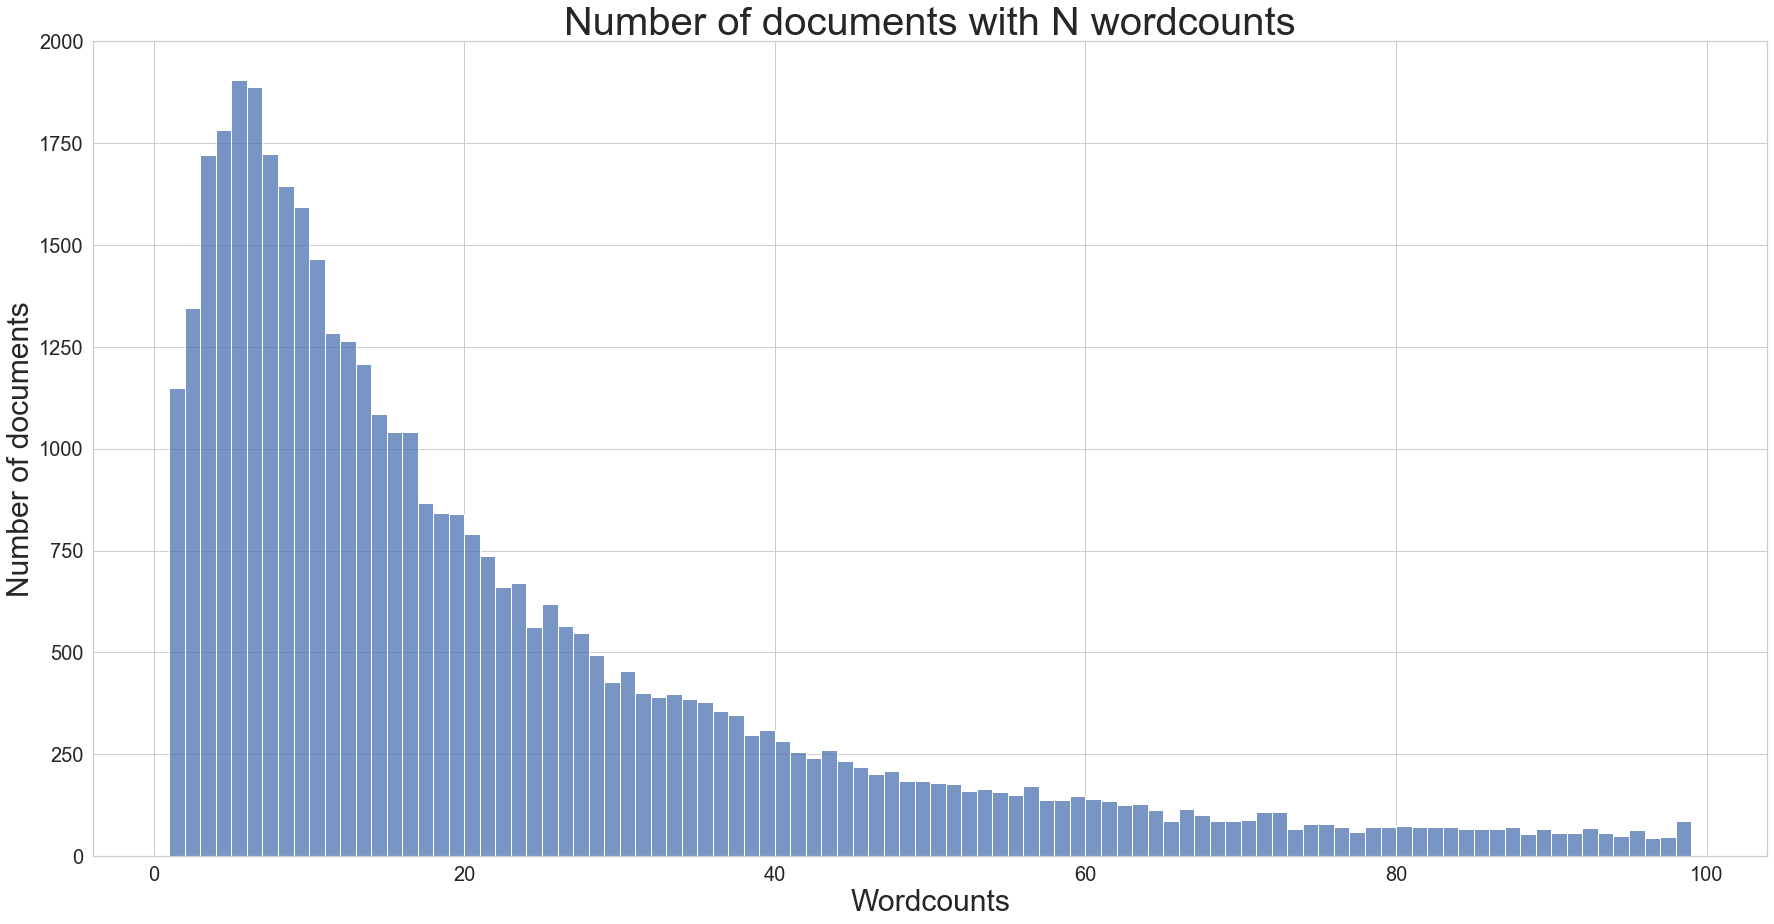

In [13]:
wc_100_df = wc_corpus[wc_corpus.wordcount < 100]

plt.rcParams['figure.figsize'] = [30, 15]
sns.set_theme(style="whitegrid")
h = sns.histplot(wc_100_df, x="wordcount", binwidth=1)
h.axes.set_title("Number of documents with N wordcounts",fontsize=40)
h.set_xlabel("Wordcounts",fontsize=30)
h.set_ylabel("Number of documents",fontsize=30)
h.tick_params(labelsize=20, axis='x')
h.tick_params(labelsize=20, axis='y')
plt.show()

The wordcount plot shows a right skew distribution and clearly there's greater number of documents with lesser wordcount. Consider the wordcount approximately at 2, 5, 10, 20 and compare with each other to decide the threshold that best describe that particular document.

In [14]:
pd.set_option('display.max_colwidth', None)
wc_100_df[wc_100_df.wordcount == 2].head()

,subreddit,full_transcript,wordcount
1150,TrueOffMyChest,what field,2
1151,explainlikeimfive,found ground,2
1152,explainlikeimfive,nice point,2
1153,TrueOffMyChest,i pologize,2
1154,memes,go on,2


In [15]:
wc_100_df[wc_100_df.wordcount == 5].head()

,subreddit,full_transcript,wordcount
5998,Damnthatsinteresting,shhh your racism is leaking,5
5999,therewasanattempt,rconservative is basically reddit’s toilet,5
6000,therewasanattempt,hell slap it up him,5
6001,MaliciousCompliance,silliness increases\n\nrubs hands\n\nexcellent,5
6002,tifu,its called an educated guess,5


In [16]:
wc_100_df[wc_100_df.wordcount == 10].head()

,subreddit,full_transcript,wordcount
14751,TooAfraidToAsk,okay is it tone volume accent vocabulary emotions physical movement,10
14752,memes,gtyou made me snort\n\nwhy you snorting crack in class,10
14753,memes,ah the peasant spirit is alive and well i see,10
14754,pcgaming,interesting i bet pros would love this for their training,10
14755,TooAfraidToAsk,do you think it is unacceptable in every context then,10


In [17]:
wc_100_df[wc_100_df.wordcount == 20].head()

,subreddit,full_transcript,wordcount
25684,sysadmin,thats a great question i dont have the full details but it is my impression it is a msp gig,20
25685,unpopularopinion,cremation is actually very bad for the environment the amount of fuel required to cremate a body is very high,20
25686,worldnews,i dont think an armed citizens would be any different unless they allowed them to have tanks and fighter jets,20
25687,buildapc,yeah but it expires like next week and i dont know im interested in tech and have a gift card,20
25688,funny,if i was named vern i would probably also want all of westeros to call me by littlefinger as well,20


We want to ensure each document is meaningful to the topic modeling.
- Documents with wordcount of 2 contain totally garbage value and doesn't provide any meaning to the document
- Documents with wordcount of 5 mostly describe the title of an image and belong to subreddits associated with entertainment. It's interesting to observe that these sentences come along with sarcasm tones and this might be a difficult task for machine to learn.
- Documents with wordcount of 10 involve exchange of findings and reflection based on initial ideas, some of them involve sarcasm tones.
- Documents with wordcount of 20 belong to contextualised data that is useful to the documents and some of them provide a concrete solution to the initial discussion.

Based on the observation above, minimum word count of each document is set to 10, because we can see that word count with 10 starting to provide some useful information about the subreddit itself although some of it contain sarcasm context. <b>Threshold ~ 10</b>

In [18]:
# Minimum word count
min_wc = 10 
cleaned_corpus = wc_corpus[wc_corpus.wordcount >= min_wc]
cleaned_corpus.head()

,subreddit,full_transcript,wordcount
14751,TooAfraidToAsk,okay is it tone volume accent vocabulary emotions physical movement,10
14752,memes,gtyou made me snort\n\nwhy you snorting crack in class,10
14753,memes,ah the peasant spirit is alive and well i see,10
14754,pcgaming,interesting i bet pros would love this for their training,10
14755,TooAfraidToAsk,do you think it is unacceptable in every context then,10


In [19]:
print("Number of documents:", len(cleaned_corpus))

Number of documents: 30095


#### Export cleaned data

In [20]:
cleaned_corpus.to_csv('cleaned_corpus.csv', index=False)

#### Frequency Filter

In [21]:
from collections import Counter

# flat_list = []
# for sublist in data_words_bigrams:
#     for item in sublist:
#         flat_list.append(item)

cnt = Counter()
for text in cleaned_corpus.full_transcript.values:
    for word in text.split():
        cnt[word] += 1

common_df = pd.DataFrame()
common_df["word"] = [w for (w, wc) in cnt.most_common()]
common_df["frequency"] = [wc for (w, wc) in cnt.most_common()]
common_df.head()

,word,frequency
0,the,49648
1,to,35329
2,a,31439
3,and,28854
4,i,24948


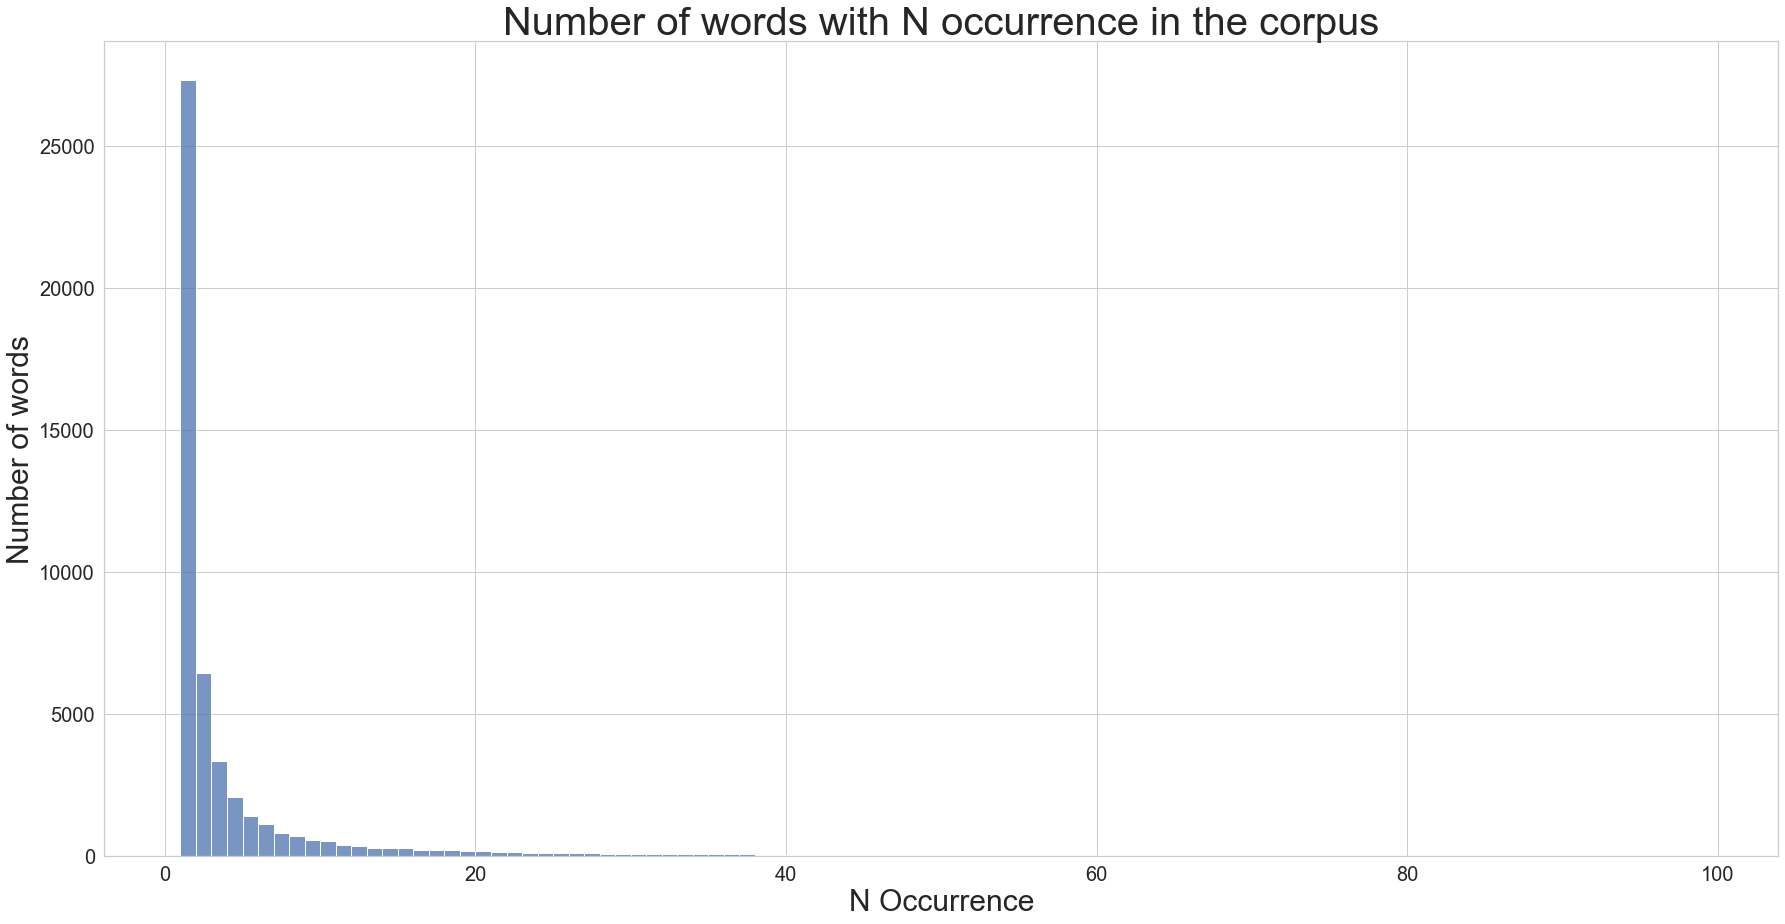

In [22]:
common_100_df = common_df[common_df.frequency < 100]

plt.rcParams['figure.figsize'] = [30, 15]
sns.set_theme(style="whitegrid")
h = sns.histplot(common_100_df, x="frequency", binwidth=1)
h.axes.set_title("Number of words with N occurrence in the corpus",fontsize=40)
h.set_xlabel("N Occurrence",fontsize=30)
h.set_ylabel("Number of words",fontsize=30)
h.tick_params(labelsize=20, axis='x')
h.tick_params(labelsize=20, axis='y')
plt.show()

Visualize the top 100 words frequency and we'll notice a right skew distribution. The threshold of frequency is set to be 1 as there's a huge gap of around 25000 for the number of words which occured only 1 times and remaining words. These rare and unique words which appear less likely in the corpus should be removed since these are essentially the weak features of the corpus. <b>Threshold ~ 1</b>

In [23]:
common_first_df = common_df[common_df.frequency == 1]
common_first_df.head()

,word,frequency
24154,farted,1
24155,steamdeck,1
24156,mindfucker,1
24157,50gb,1
24158,srts,1


It's obvious that these rare words is mostly <b>due to spelling error</b>. So should we correct these spelling error using natural language tools? In this case, I would be more cautious about the usage of words in each documents, therefore I decide to remove these words instead of correcting all the spelling, since the nlp tools might classify the semantic meaning of each word incorrectly that form along with sentences. 

In [24]:
# Threshold is set as 1
N = 1
add_stop_words = [word for word, count in cnt.most_common() if count <= N]
print("Number of extra stopwords: ", len(add_stop_words))

Number of extra stopwords:  27348


Add these data as extra stopwords and remove them along with the original stopwords afterward.

In [25]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(add_stop_words)

####  Bigrams & Trigrams Architecture
Perform word tokenization, stopwords removal, make bigrams/trigrams and lemmatization and evaluate the result. Eventually, I decide to use <b>trigram architecture</b>.

---
Remove stopwords, make Bigram and Trigram using <b>Phrases from Gensim library</b>.
- min_count: ignore all words and bigrams with total collected count lower than this. 
- threshold: represents a threshold for forming the phrases (higher means fewer phrases). A phrase of words a and b is accepted if (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold, where N is the total vocabulary size.

---
<b>PS. All the decision made below on unigram/bigram/trigram are based on conclusion of multiple failed attempt on extracting important topics from LDA model. Hence, I've create another notebook for these failed attempts and clarify the findings here: https://github.com/leslieyuandev/Topic-Modeling-with-Latent-Dirichlet-Allocation-LDA-/blob/main/Notebooks/%23%23%23_topic_modeling_n_gram%23%23%23.ipynb.</b>

In [26]:
import gensim
from gensim.utils import simple_preprocess

# Perform another simple preprocess just to make sure along with tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data = cleaned_corpus.full_transcript.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['okay', 'is', 'it', 'tone', 'volume', 'accent', 'vocabulary', 'emotions', 'physical', 'movement']


In [72]:
# Threshold set to 2 since there too few phrases that can be form due to the preprocessing steps above especially by removing stopwords.
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=2)
trigram = gensim.models.Phrases(bigram[data_words], threshold=2)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [49]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove stopwords

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [50]:
data_words_nostops = remove_stopwords(data_words)

In [56]:
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

#### Bigrams & Trigrams Analysis

In [122]:
bigram2_dict={}
for ngrams, count in list(bigram.vocab.items()):
    unicode_ngrams = ngrams
    if '_' in unicode_ngrams:
        bigram2_dict[unicode_ngrams] = count
        
bigram2_df = pd.DataFrame(bigram2_dict.items(), columns=['Bigrams', 'Frequency']).sort_values(by="Frequency", ascending=False)
bigram2_df.head()

,Bigrams,Frequency
84,of_the,3772
124,in_the,3763
402,if_you,2798
232,to_be,2479
529,on_the,2010


In [120]:
bigram_nostop = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=2)
trigram_nostop = gensim.models.Phrases(bigram[data_words_nostops], threshold=2)

bigram_dict={}
for ngrams, count in list(bigram_nostop.vocab.items()):
    unicode_ngrams = ngrams
    if '_' in unicode_ngrams:
        bigram_dict[unicode_ngrams] = count
        
bigram_df = pd.DataFrame(bigram_dict.items(), columns=['Bigrams', 'Frequency']).sort_values(by="Frequency", ascending=False)
bigram_df.head()

,Bigrams,Frequency
432502,caw_caw,863
552,dont_know,359
897,feel_like,322
5286,dont_think,314
95641,questions_concerns,305


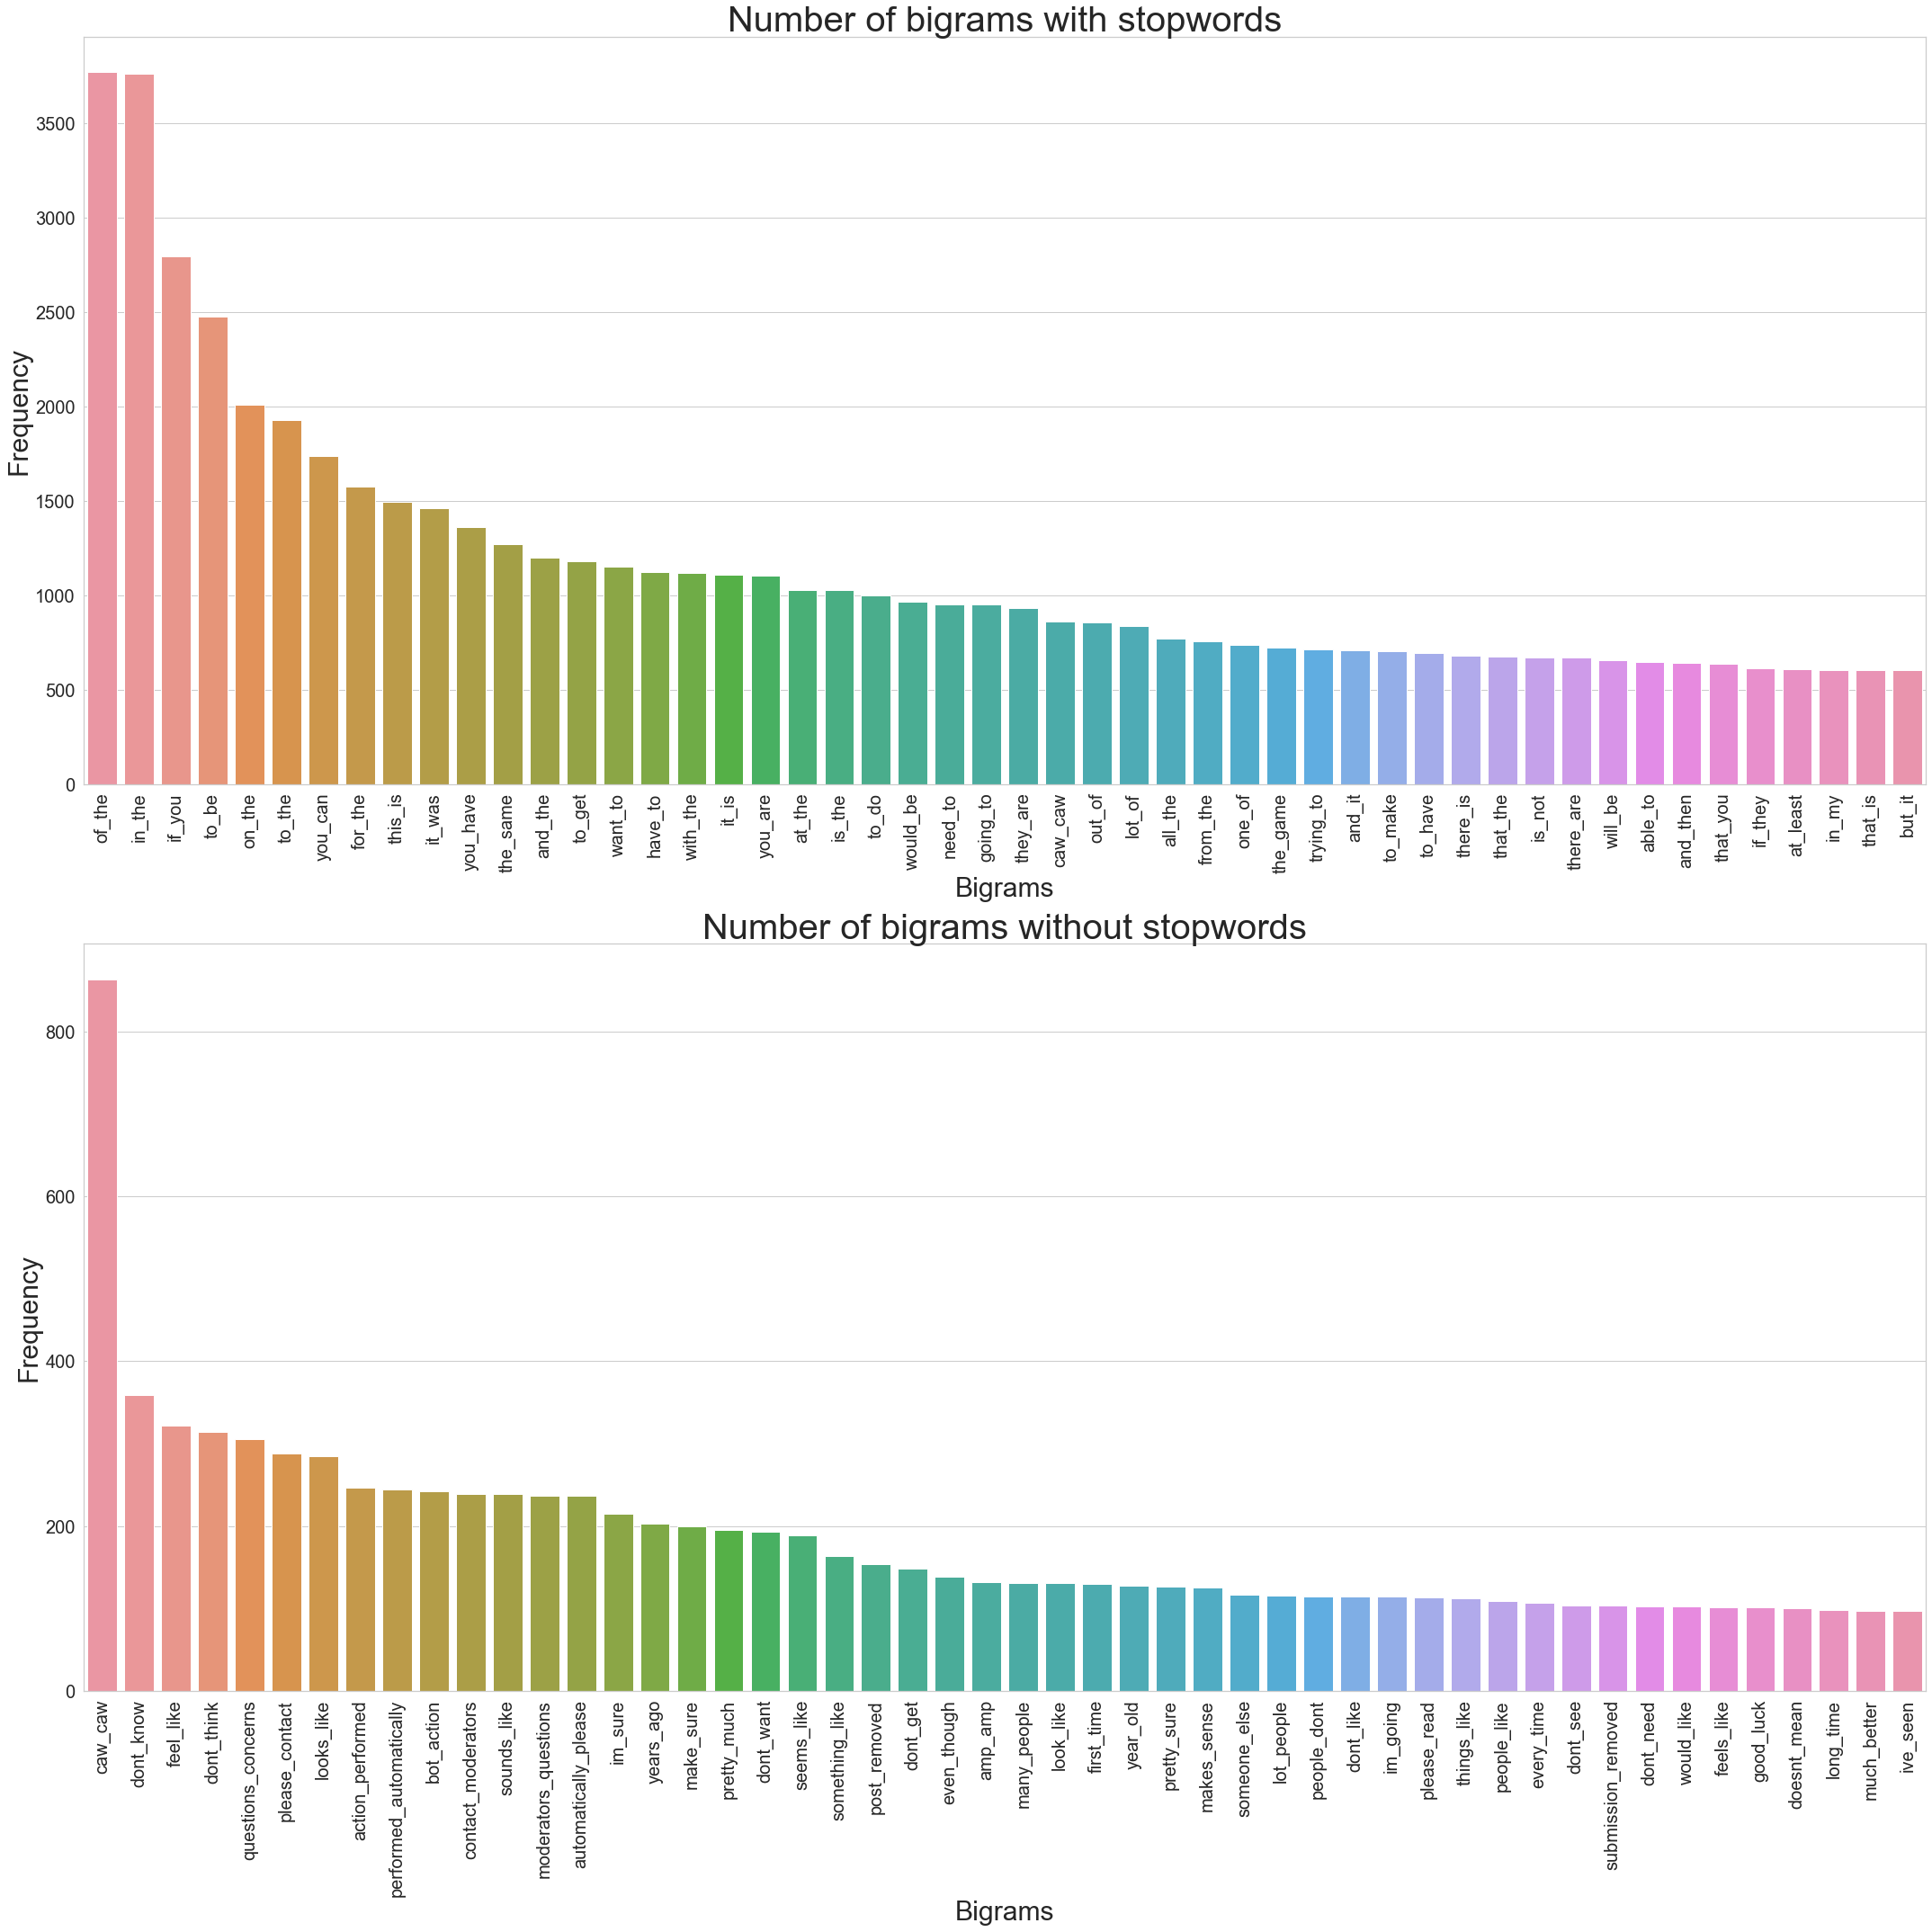

In [147]:
f, axes = plt.subplots(2,1, figsize=(30,30))
# plt.rcParams['figure.figsize'] = [30, 30]
sns.set_theme(style="whitegrid")

bp = sns.barplot(x="Bigrams", y="Frequency", data=bigram2_df[:50], ax=axes[0])
bp.axes.set_title("Number of bigrams with stopwords",fontsize=40)
bp.set_xlabel("Bigrams",fontsize=30)
bp.set_ylabel("Frequency",fontsize=30)
bp.tick_params(labelsize=20, axis='x', rotation=90)
bp.tick_params(labelsize=20, axis='y')

bp = sns.barplot(x="Bigrams", y="Frequency", data=bigram_df[:50], ax=axes[1])
bp.axes.set_title("Number of bigrams without stopwords",fontsize=40)
bp.set_xlabel("Bigrams",fontsize=30)
bp.set_ylabel("Frequency",fontsize=30)
bp.tick_params(labelsize=20, axis='x', rotation=90)
bp.tick_params(labelsize=20, axis='y')

f.tight_layout()
plt.show()

In [151]:
trigram2_dict = {}
for ngrams, count in list(trigram.vocab.items()):
    unicode_ngrams = ngrams
    if unicode_ngrams.count('_') >= 2:
        trigram2_dict[unicode_ngrams] = count
        
trigram2_df = pd.DataFrame(trigram2_dict.items(), columns=['Trigrams', 'Frequency']).sort_values(by="Frequency", ascending=False)
trigram2_df.head()

,Trigrams,Frequency
235323,caw_caw_caw_caw,431
45016,if_you_have_any,276
53116,this_action_was_performed,247
53121,have_any_questions_or,243
44250,this_if_you,242


In [152]:
trigram_dict = {}
for ngrams, count in list(trigram_nostop.vocab.items()):
    unicode_ngrams = ngrams
    if unicode_ngrams.count('_') >= 2:
        trigram_dict[unicode_ngrams] = count
        
trigram_df = pd.DataFrame(trigram_dict.items(), columns=['Trigrams', 'Frequency']).sort_values(by="Frequency", ascending=False)
trigram_df.head()

,Trigrams,Frequency
51439,caw_caw_caw_caw,431
10191,action_performed_automatically,244
10193,please_contact_moderators,236
10192,performed_automatically_please_contact,236
19196,questions_concerns_please,64


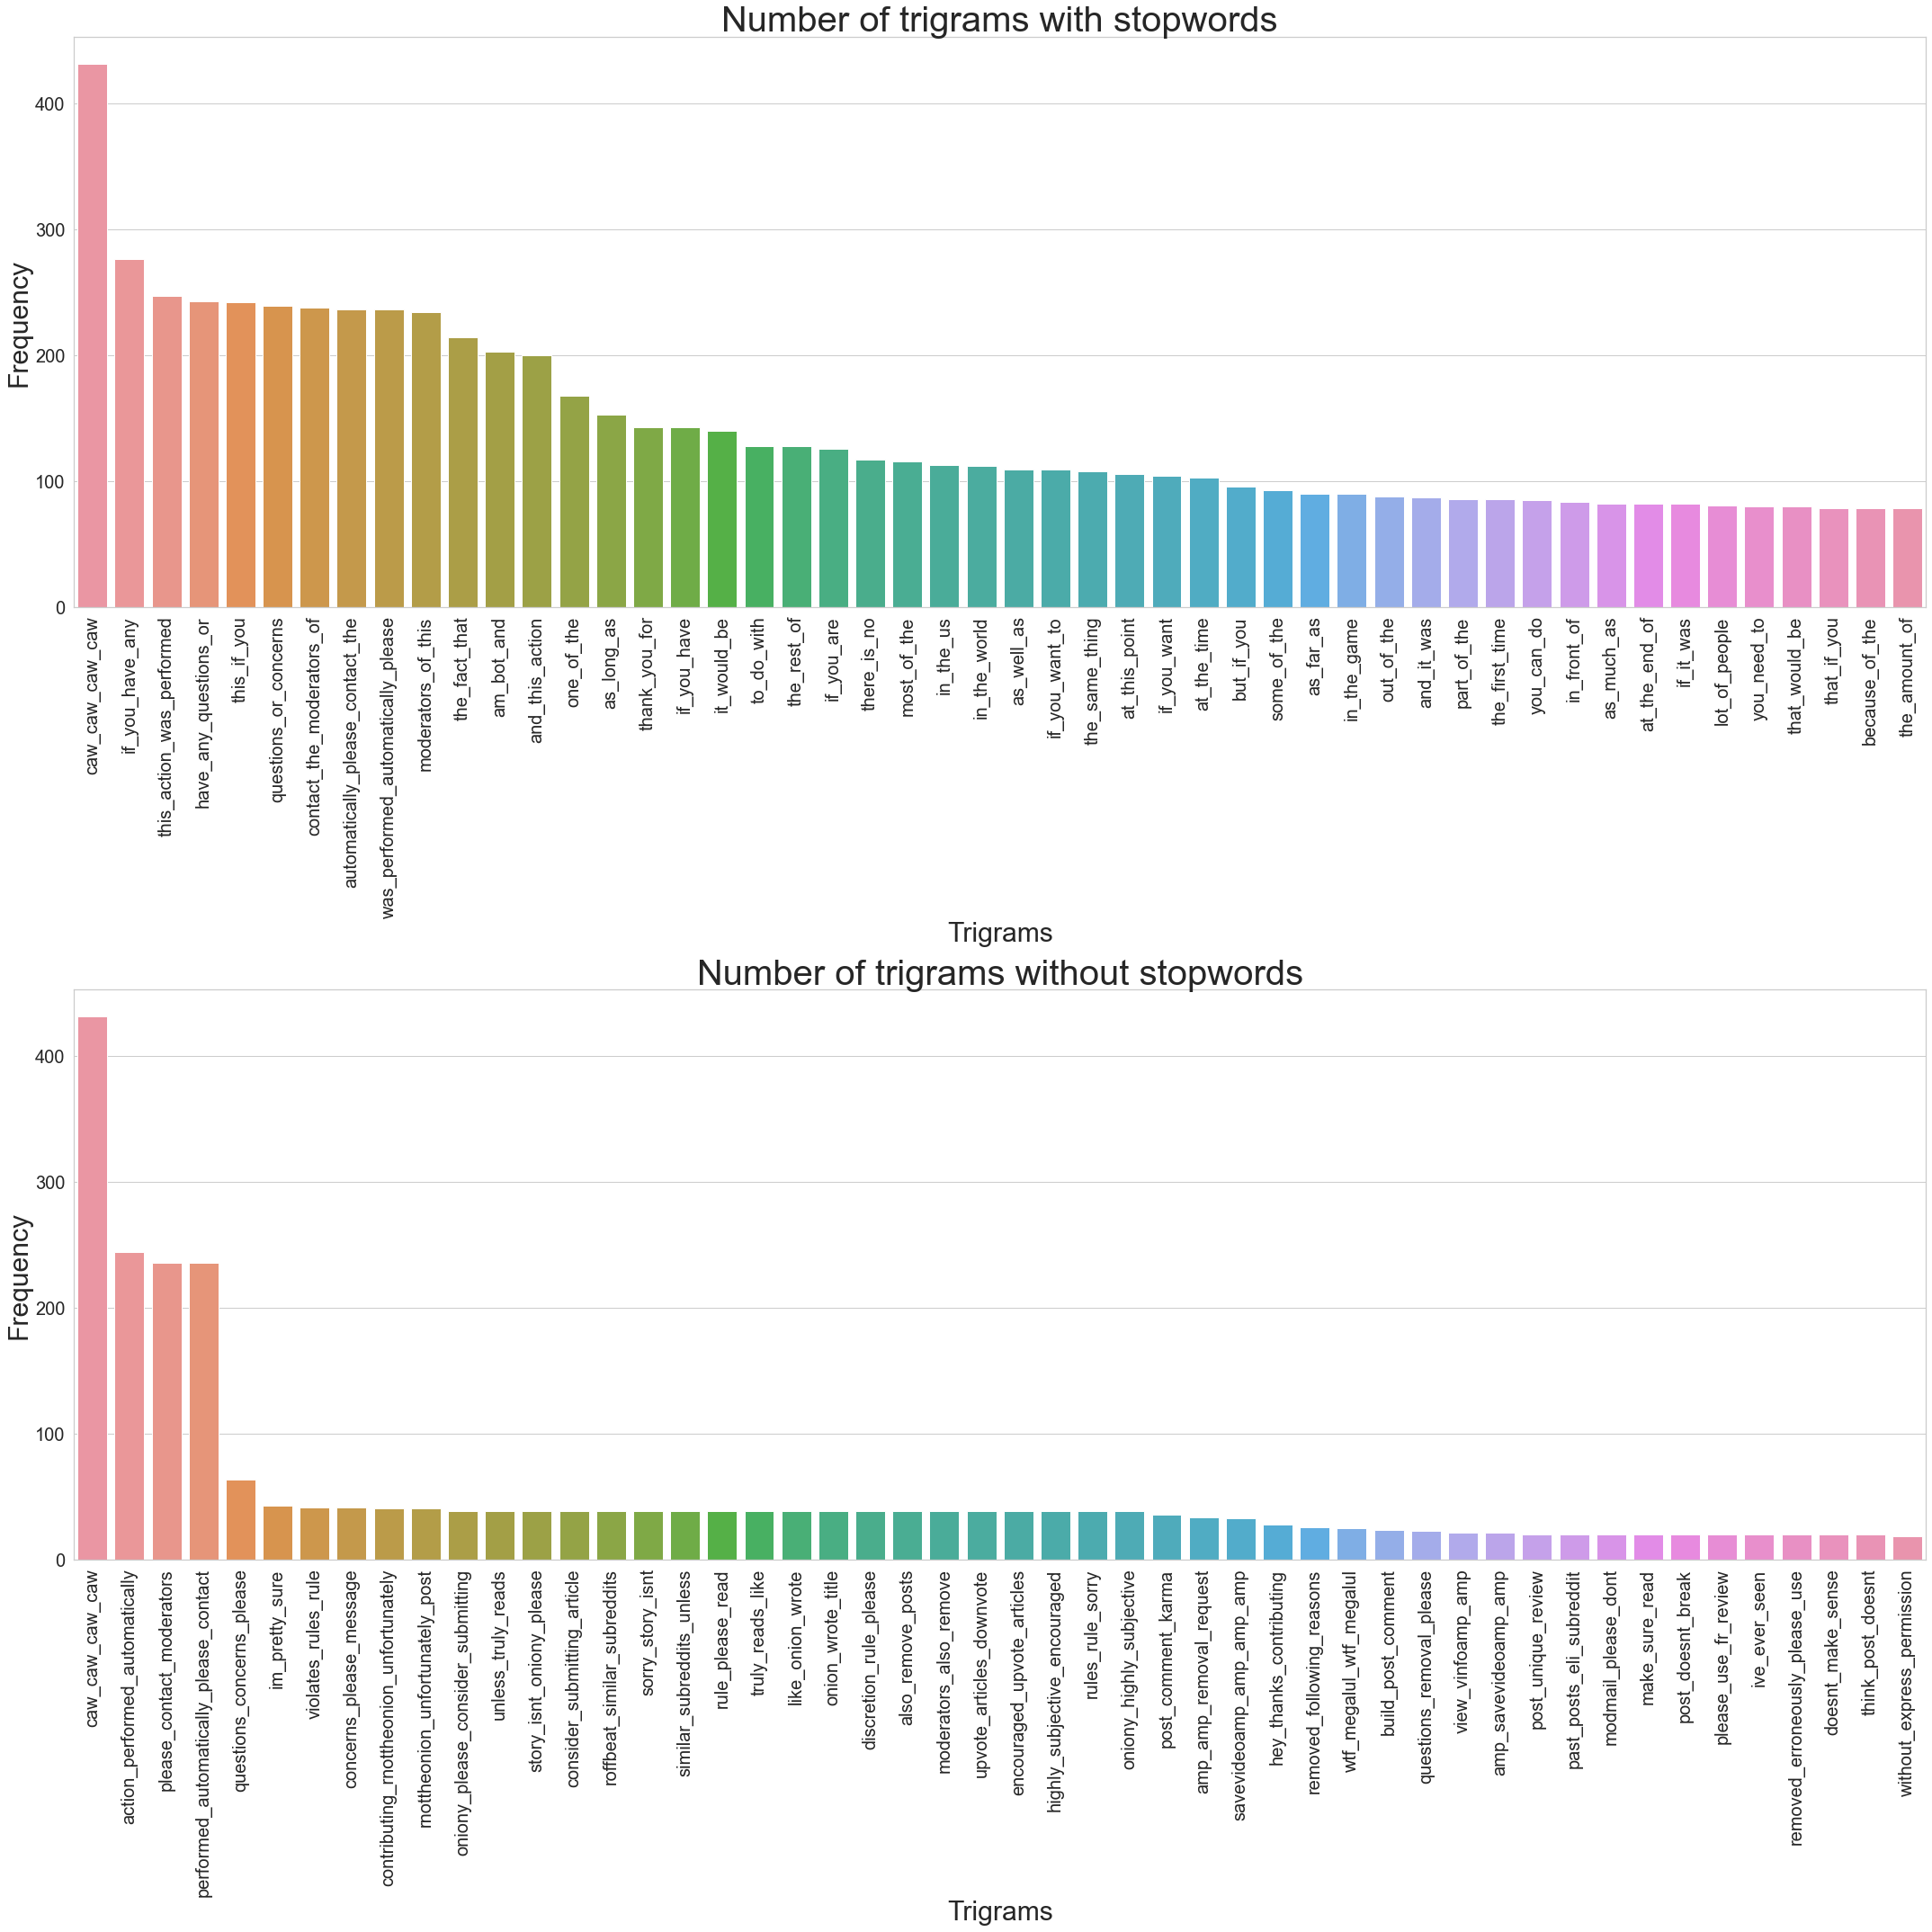

In [153]:
f, axes = plt.subplots(2,1, figsize=(30,30))
# plt.rcParams['figure.figsize'] = [30, 30]
sns.set_theme(style="whitegrid")

bp = sns.barplot(x="Trigrams", y="Frequency", data=trigram2_df[:50], ax=axes[0])
bp.axes.set_title("Number of trigrams with stopwords",fontsize=40)
bp.set_xlabel("Trigrams",fontsize=30)
bp.set_ylabel("Frequency",fontsize=30)
bp.tick_params(labelsize=20, axis='x', rotation=90)
bp.tick_params(labelsize=20, axis='y')

bp = sns.barplot(x="Trigrams", y="Frequency", data=trigram_df[:50], ax=axes[1])
bp.axes.set_title("Number of trigrams without stopwords",fontsize=40)
bp.set_xlabel("Trigrams",fontsize=30)
bp.set_ylabel("Frequency",fontsize=30)
bp.tick_params(labelsize=20, axis='x', rotation=90)
bp.tick_params(labelsize=20, axis='y')

f.tight_layout()
plt.show()

As we can see, both bigrams and trigrams are more contextualised without stopwords such that the most commonly used n-grams with stopwords mostly start with <b>"if_"</b> and it doesn't provide any value to the model. Furthermore, the bigrams and trigrams are not all contextualise, there's grams such as <b>"dont_know", "feel_like", "dont_think", "im_pretty_sure"</b> which doesn't help the model at all. Something to consider, does these phrases modeling actually help? If yes, which one is better? Bigrams or trigrams?  In my opinion, I would say trigram best fit our use case, a much more contextualized model and it was clearly build upon bigrams model.

#### Export bigrams and trigrams data

In [159]:
import pickle

file_name = "unigrams"
open_file = open(file_name, "wb")
pickle.dump(data_words_nostops, open_file)
open_file.close()

file_name = "bigrams"
open_file = open(file_name, "wb")
pickle.dump(data_words_bigrams, open_file)
open_file.close()

file_name = "trigrams"
open_file = open(file_name, "wb")
pickle.dump(data_words_trigrams, open_file)
open_file.close()

#### Lemmatization by fine tuning the POS tag.
It's important to identify the suitable POS tag associated to our desire topics and eventually I decide to used the model that react to <b>nouns and adjectives</b>.
- Nouns, Adjectives, Verb, Adverb
- Nouns, Adjectives
- Nouns

<b>PS. All the decision made below on fine tuning the POS tag are based on conclusion of multiple failed attempt on extracting important topics from LDA model. Hence, I've create another notebook for these failed attempts and clarify the findings here: https://github.com/leslieyuandev/Topic-Modeling-with-Latent-Dirichlet-Allocation-LDA-/blob/main/Notebooks/%23%23%23_topic_modeling_pos_tag%23%23%23.ipynb.</b>

In [160]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 1400000

# Do lemmatization keeping noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VB', 'ADV'])
data_lemmatized_NA = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ'])
data_lemmatized_N = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])
print("NAVA:", data_lemmatized[:20])
print("NA:", data_lemmatized_NA[:20])
print("N", data_lemmatized_N[:20])

NAVA: [['tone', 'volume', 'vocabulary', 'emotion', 'physical', 'movement'], ['snort', 'crack', 'class'], ['peasant', 'spirit', 'alive', 'well'], ['interesting', 'bet', 'pro', 'training'], ['unacceptable', 'context'], ['ever', 'cookie'], ['long', 'feeling', 'wrong'], ['work', 'holy', 'one'], ['suspect', 'theory', 'already', 'phase'], ['quality', 'game'], ['star', 'rating'], ['good', 'world'], ['even', 'botw', 'lmao', 'recommendation', 'terrible'], ['never', 'reason', 'use'], ['first', 'half'], ['odst', 'proper', 'multiplayer', 'right', 'firefight'], ['sun', 'radiation', 'outside'], ['quick', 'game'], ['thing', 'ever'], ['appreciate']]
NA: [['tone', 'volume', 'vocabulary', 'emotion', 'physical', 'movement'], ['snort', 'crack', 'class'], ['peasant', 'spirit', 'alive'], ['interesting', 'bet', 'pro', 'training'], ['unacceptable', 'context'], ['cookie'], ['long', 'feeling', 'wrong'], ['work', 'holy', 'one'], ['suspect', 'theory', 'phase'], ['quality', 'game'], ['star', 'rating'], ['good', 'w

In [161]:
import pickle

file_name = "NAVA"
open_file = open(file_name, "wb")
pickle.dump(data_lemmatized, open_file)
open_file.close()

file_name = "NA"
open_file = open(file_name, "wb")
pickle.dump(data_lemmatized_NA, open_file)
open_file.close()

file_name = "N"
open_file = open(file_name, "wb")
pickle.dump(data_lemmatized_N, open_file)
open_file.close()